In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten

import requests
from io import BytesIO

import PIL
from PIL import Image, ImageFilter

import os
import pickle 
from scipy.spatial import distance

## Note:
All images used in this code are scraped from Wayfair.com and are saved with their SKU number according to Wayfair.
Please look at the other notebook to see code for scraping.

# VGG16 Architecture

In [15]:
vgg_16 = VGG16()
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
## FC1 layer is the feature extractor layer that will be used for the model! 

# Transfer Learning Model

In [2]:
# Step 1 >>> Build the feature extractor
class FeatureExtractor:
    
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    
    def extract(self, img):
        
        '''
        input: image 
        output: a normalized vetor of numbers (features) extracted from input
        
        '''
        
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)


In [ ]:
# Step 2 >>> Save the absolute Path of each inventory

image_paths = []
    
for image_name in os.listdir("./images/wayfair/chair"):
    if '.png' in image_name:
        try:
            image_path = os.path.join("./images/wayfair/chair" , image_name)
            image_paths.append(image_path)

        except:
            pass
        

        #save the image paths:
with open("model/image_paths.txt", "wb") as fp:   #Pickling
    pickle.dump(image_paths, fp)

# Load image_paths:
with open("model/image_paths.txt", "rb") as fp:   # Unpickling
    image_paths = pickle.load(fp)

In [ ]:
## Step 3 >>> extracting features of each image (inputs from step2) as an array and saving them on a .npy file 

fe =  FeatureExtractor()   
# Iterate through images (paths are saved as a .txt file)

array_lst = []
for img_path in image_paths:
    
    # Extract Features
    feature = fe.extract(img=PIL.Image.open(img_path))
    array_lst.append(feature)
    # Save the Numpy array (.npy) on designated path
    #feature_path = "/Users/bahar/Desktop/test/feat/.npy"
    #np.save(feature_path, feature)
    
np.save('model/alloffeatnumpy.npy', array_lst)

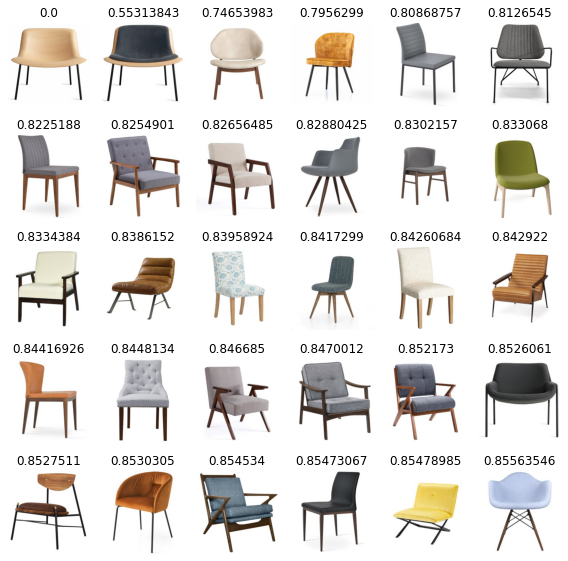

In [11]:
## Step 4 >>> Extracting query features, comparing with database features and returning the most similar ones

array_reloaded = np.load('model/alloffeatnumpy.npy')

fe = FeatureExtractor()

# Insert the image query
img = Image.open("/Users/bahar/Desktop/test/ABFR1130.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = np.linalg.norm(array_reloaded - query, axis=1)
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id][1]) for id in ids]
# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

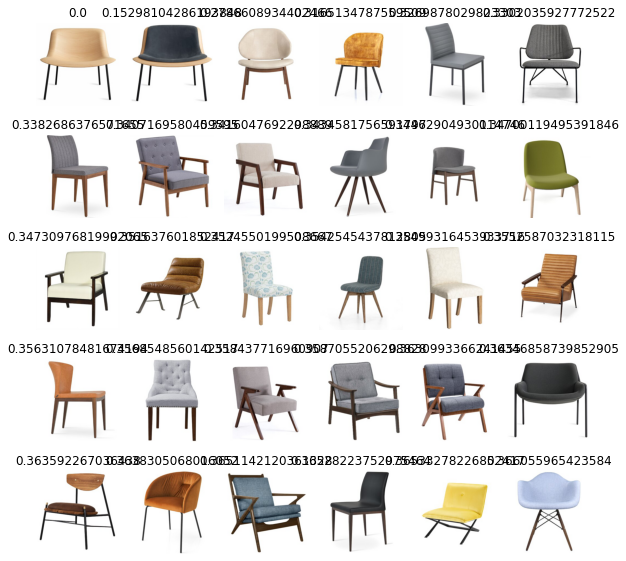

In [76]:
### same step with COSINE SIMILARITY >>>> results are the same #####

from scipy.spatial import distance

# Insert the image query
img = Image.open("/Users/bahar/Desktop/test/ABFR1130.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = []
for i in array_reloaded:
    dists.append(distance.cosine(i , query))
dists = np.array(dists)    
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id]) for id in ids]
# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

 ## SAVING IMAGE PATHS FOR the APP

In [15]:
image_paths = []
    
for image_name in os.listdir("./app/static/inventory/chair"):
    if '.png' in image_name:
        try:
            sku = image_name[:-4]
            image_path = os.path.join("./static/inventory/chair" , image_name)
            image_paths.append((sku, image_path))

        except:
            pass
        
#save the image paths:
with open("app/static/image_paths.txt", "wb") as fp:   #Pickling
    pickle.dump(image_paths, fp)

# Load image_paths:
with open("app/static/image_paths.txt", "rb") as fp:   # Unpickling
    image_paths = pickle.load(fp)

## TEST1

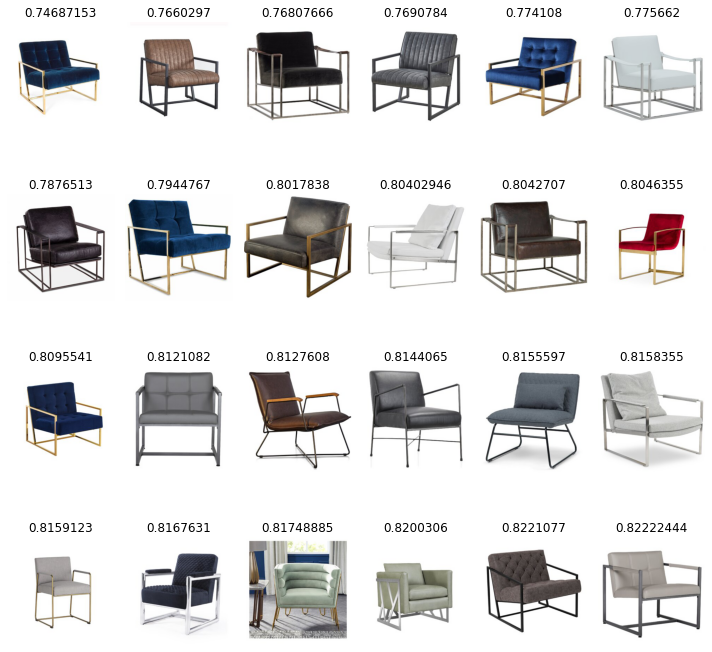

In [14]:
# Insert the image query
img = Image.open("/Users/bahar/Desktop/search/5.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = np.linalg.norm(array_reloaded - query, axis=1)
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id][1]) for id in ids]
# Visualize the result
#print(scores)
axes=[]
fig=plt.figure(figsize=(10,10))
for a in range(4*6):
    score = scores[a]
    axes.append(fig.add_subplot(4, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()


## TEST2

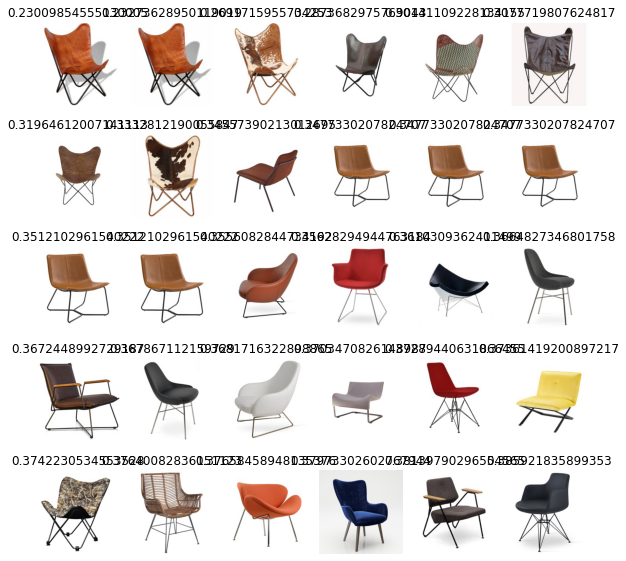

In [77]:
### COSINE SIMILARITY #####

from scipy.spatial import distance

# Insert the image query
img = Image.open("/Users/bahar/Desktop/search/6.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = []
for i in array_reloaded:
    dists.append(distance.cosine(i , query))
dists = np.array(dists)    
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id]) for id in ids]
# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

## AutoEncoders

<div class="alert-success">
Autoencoders  >>>>>>>>> NOTE: This model is NOT USED in the final product since VGG16 has better results  <<<<<<<<<
</div>

In [144]:
import pandas as pd
import numpy as np
import os
import cv2
import pickle
import json
import numpy as np
from scipy import spatial

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Image

In [117]:
epochs = 5
batch_size = 1
image_dimension = 200

In [118]:
# Input layer
input_img = Input(shape=(image_dimension, image_dimension, 3))

# Encoding layers
x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)

# Decoding layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Instanstiate Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [119]:
# View parameter summary
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 200, 200, 512)     14336     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 100, 100, 512)     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 100, 100, 64)      294976    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 50, 50, 16)        9232      
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 16)        0   

## Transform Images for Model

In [48]:
# Directories for images
base_directory = '/Users/bahar/Desktop/autoencoder/'
training_directory = os.path.join(base_directory, 'train/')
validation_directory = os.path.join(base_directory, 'validate/')
test_directory = os.path.join(base_directory, 'test/')

In [49]:
# Sample files used to train model drawn from all images
sample_size = 85
allimage_directory = '/Users/bahar/Desktop/autoencoder/all/'
total_image_count = len([name for name in os.listdir(allimage_directory)])
all_image_names = os.listdir(allimage_directory)
sample_indices = np.random.randint(0, total_image_count, size=sample_size)
training_sample_indices = sample_indices[:int(sample_size*.8)]
validation_sample_indices = sample_indices[int(sample_size*.8):]

In [50]:
# Copy images into training and validation folders
from shutil import copy2
for training_sample_index in training_sample_indices:
    copy2(allimage_directory + all_image_names[training_sample_index], training_directory + all_image_names[training_sample_index])
for validation_sample_index in validation_sample_indices:
    copy2(allimage_directory + all_image_names[validation_sample_index], validation_directory + all_image_names[validation_sample_index])

In [120]:
# Load images
img_height = 200
img_width = 200
channels = 3
batch_size = 1

train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    '/Users/bahar/Desktop/autoencoder/all',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    '/Users/bahar/Desktop/autoencoder/all',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 68 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


## Train Model

In [121]:
# Early stopping if epochs don't change loss
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto')


In [122]:
# Number of samples for calculating number of steps
training_samples = training_set.samples
validation_samples = validation_set.samples

# Number of steps
training_steps = training_samples // batch_size
validation_steps = validation_samples // batch_size

In [123]:
print(training_samples, validation_samples)

68 17


In [124]:
print(training_steps, validation_steps)

68 17


In [125]:
# Train model
history = autoencoder.fit_generator(
      training_set,
      steps_per_epoch=training_steps,
      epochs=epochs,
      validation_data=validation_set,
      validation_steps=None,
      callbacks=[early_stopping])

Epoch 1/5
68/68 [==============================] - 104s 2s/step - loss: 0.0846 - acc: 0.7799 - val_loss: 0.0288 - val_acc: 0.3299
Epoch 2/5
68/68 [==============================] - 110s 2s/step - loss: 0.0269 - acc: 0.6729 - val_loss: 0.0204 - val_acc: 0.7420
Epoch 3/5
68/68 [==============================] - 105s 2s/step - loss: 0.0178 - acc: 0.8531 - val_loss: 0.0186 - val_acc: 0.4742
Epoch 4/5
68/68 [==============================] - 105s 2s/step - loss: 0.0167 - acc: 0.8378 - val_loss: 0.0130 - val_acc: 0.7451
Epoch 5/5
68/68 [==============================] - 106s 2s/step - loss: 0.0155 - acc: 0.7630 - val_loss: 0.0120 - val_acc: 0.4654


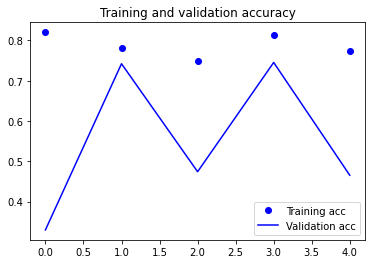

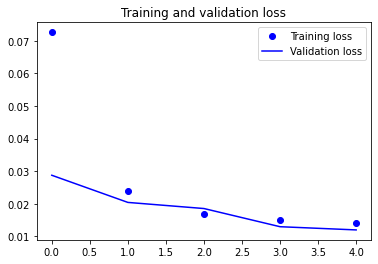

In [126]:
# Plot accuracy and loss for training and validation sets
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save model
#autoencoder.save('./autoencoder/models/autoencoder.h5')

In [127]:
# Save feature extractor
feature_extractor = \
    Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
#feature_extractor.save('./autoencoder/models/feature_extractor.h5')

## Convert Images into Tensors

In [128]:
# Functions to convert images to 3D (image_dim, image_dim, 3) 
# or 4D (1, image_dim, image_dim, 3) tensors

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

In [130]:
# Corpus directory
corpus_image_directory = '/Users/bahar/Desktop/autoencoder/all/chairs'
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

85


In [138]:
# Instantiate tensors array and list of filenames
corpus_tensors = np.zeros((1, image_dimension, image_dimension, 3))
corpus_tensors_list = []
corpus_filenames = []

In [139]:
# Create image tensors and filename list
for filename in os.listdir(corpus_image_directory):
    corpus_filenames.append(filename)
    try: 
        corpus_tensors_list.append(image_to_3d_tensor(corpus_image_directory + '/'+ filename))
    except: 
        pass

#     if len(corpus_tensors_list) % 85 == 0: print('Processed:', len(corpus_tensors_list)) 
corpus_tensors = np.array(corpus_tensors_list)

In [140]:
corpus_tensors.shape

(85, 200, 200, 3)

In [141]:
# Predict feature values using narrow encoded layer
corpus_features = feature_extractor.predict(corpus_tensors, verbose=1)

3/3 [==============================] - 10s 3s/step


## Display Original and Autoencoded Images

In [142]:
def display_orig_and_encoded(image):
    orig = image_to_3d_tensor(image)
    pred = autoencoder.predict(orig.reshape(1, image_dimension, image_dimension, 3))\
            .reshape(image_dimension, image_dimension, 3)
    # print(orig.shape, pred.shape)
    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.imshow(orig)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(pred)
    plt.title('Encoded')

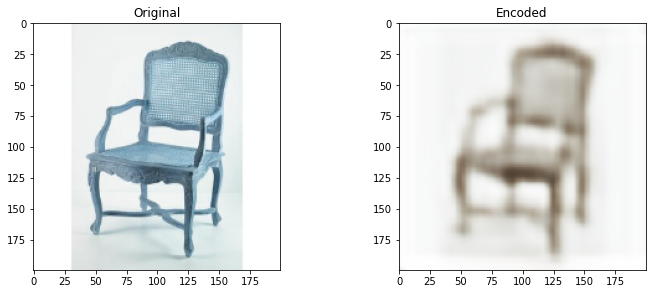

In [143]:
display_orig_and_encoded('/Users/bahar/Desktop/autoencoder/all/chairs/AAI2251.png')

## Compare Test Image to Corpus

In [161]:
def compare_test_image(test_image_file, metric='cosine'):
    
    # Display original image
    print('Original image')
    display(Image(test_image_file, width = image_dimension, height = image_dimension))
    
    # Predict feature values for test image
    test_tensor = image_to_4d_tensor(test_image_file)
    test_features = feature_extractor.predict(test_tensor)
    
    # Use a vectorized function (spatial.distance.cdist) to calculate the distance between
    # the test image and each of the images in the corpus.
    # Images need to be converted to '2d' for use in distance.cdist.
    # First dimension is number of images (1 for test, corpus size for corpus).
    # Second dimension is width x height x number of color channels.
    test_features_2d = np.reshape(test_features, (test_features.shape[0], test_features.shape[1] * test_features.shape[2] * test_features.shape[3]))
    corpus_features_2d = np.reshape(corpus_features, (corpus_features.shape[0], corpus_features.shape[1] * corpus_features.shape[2] * corpus_features.shape[3]))
    
    # Run comparison
    distance_array = spatial.distance.cdist(test_features_2d, corpus_features_2d, metric=metric)
    print(distance_array)
    

    # If #1 best match is indistinguishable from test image, skip 
    
    print(distance_array.argsort()[0][0:5].tolist())
        
    # Return top 5 id numbers using argsort
    top5ids = [corpus_filenames[index][:-4] for index in distance_array.argsort()[0][0:5].tolist()]
    top5list = []
    
    print('Closest matches')
    
    return(top5ids)

Original image


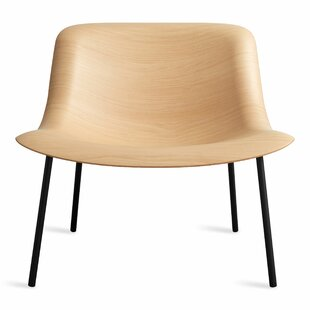

[[5.49449718e-01 1.91017155e-01 3.45875335e-01 2.93940716e-01
  1.47030399e-01 1.49912939e-01 3.23709048e-01 2.70632257e-01
  2.21177610e-01 1.82968255e-01 8.11279394e-02 5.05253975e-01
  2.80097842e-01 2.43507071e-01 1.31480833e-01 1.28062392e-01
  1.26958794e-01 1.26963527e-01 9.01319053e-02 2.15754579e-01
  1.48632136e-01 1.34845583e-01 2.80219436e-01 2.13711109e-01
  2.15653532e-01 2.12315472e-01 3.86732768e-01 2.35557097e-01
  9.31045155e-02 1.51616008e-01 7.25244614e-02 4.23006347e-01
  1.17916251e-01 2.39295593e-01 4.52957600e-02 1.13834226e-01
  2.54580410e-01 3.38491325e-01 5.14077066e-01 5.15187119e-02
  4.84215308e-01 5.32073942e-01 7.99493175e-02 2.49944796e-01
  4.19857109e-01 2.37577518e-01 3.76726279e-01 1.50860656e-01
  4.50479240e-01 1.11022302e-16 7.84317854e-02 9.04657774e-02
  2.16380823e-01 2.24836153e-01 1.44370509e-01 2.04347951e-01
  2.16446975e-01 2.01351582e-01 5.05925359e-02 2.64899985e-01
  1.42815579e-01 3.07601204e-01 2.53002614e-01 2.78365494e-01
  9.1939

['ABFR1130', 'AGRV4836', 'AEIT1018', 'AAI2251', 'AHSU1714']

In [162]:
compare_test_image('/Users/bahar/Desktop/autoencoder/all/chairs/ABFR1130.png', metric='cosine')

In [50]:
with open("./app/static/image_paths.txt", "rb") as fp: # Unpickling
        image_paths = pickle.load(fp)

In [51]:
print(image_paths[0:10])

[('W003548903', './static/inventory/chair/W003548903.png'), ('W000857722', './static/inventory/chair/W000857722.png'), ('W002266226', './static/inventory/chair/W002266226.png'), ('W005405227', './static/inventory/chair/W005405227.png'), ('W004761342', './static/inventory/chair/W004761342.png'), ('QO10036', './static/inventory/chair/QO10036.png'), ('W001641658', './static/inventory/chair/W001641658.png'), ('W004713918', './static/inventory/chair/W004713918.png'), ('W002098632', './static/inventory/chair/W002098632.png'), ('W000100010', './static/inventory/chair/W000100010.png')]
